In [1]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import timedelta
import datetime


from project_functions import *

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics, cluster, decomposition
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.pipeline import Pipeline, make_pipeline

# Clustering Librairies import
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

# Lecture des données

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

In [2]:
data = pd.read_pickle('data_clients.pickle')

In [3]:
data.head()

,customer_unique_id,date_last_order,days_last_order,nb_orders,total_spend,mean_price_order,mean_review_score,total_items,mean_nb_items,zip_code
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1481,1,129.90,129.90,5.0,1,1.0,7787
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1483,1,18.90,18.90,4.0,1,1.0,6053
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1906,1,69.00,69.00,3.0,1,1.0,88115
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1690,1,25.99,25.99,4.0,1,1.0,66812
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1657,1,180.00,180.00,5.0,1,1.0,18040


In [4]:
data.drop(["zip_code"], axis=1, inplace = True)

In [5]:
data.isna().sum()

customer_unique_id      0
date_last_order         0
days_last_order         0
nb_orders               0
total_spend             0
mean_price_order        0
mean_review_score     603
total_items             0
mean_nb_items           0
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

customer_unique_id    0
date_last_order       0
days_last_order       0
nb_orders             0
total_spend           0
mean_price_order      0
mean_review_score     0
total_items           0
mean_nb_items         0
dtype: int64

In [8]:
data.set_index("customer_unique_id", inplace=True)

In [9]:
data.head()

,date_last_order,days_last_order,nb_orders,total_spend,mean_price_order,mean_review_score,total_items,mean_nb_items
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1481,1,129.90,129.90,5.0,1,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1483,1,18.90,18.90,4.0,1,1.0
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1906,1,69.00,69.00,3.0,1,1.0
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1690,1,25.99,25.99,4.0,1,1.0
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1657,1,180.00,180.00,5.0,1,1.0


---

# Méthode

Nous devons vérifier à partir de quel moment les clients changent de segment. 

Dans le but d'établir un contrat de maintenant du programme de segmentation, nous devons tester sa stabilité dans le temps.

Ainsi, on réalise les étapes suivantes :

- Segmentation de référence sur une période d'un an avec date de départ = t0
- Segmentation sur une période d'un an avec date de départ décalé (t0 + delta_days)
- Comparaison des segmentations grâce au calcul de l'indice de rang ajusté (ARI).

# Données initiales :

Observons la durée totale du dataset :

In [10]:
data['date_last_order'].max().date() - data['date_last_order'].min().date()

datetime.timedelta(days=713)

Maintenant la date de début et la date de fin :

In [11]:
print(f"Premier jour de la BDD : {data['date_last_order'].min().date()}")
print(f"Dernier jour de la BDD : {data['date_last_order'].max().date()}")

Premier jour de la BDD : 2016-09-15
Dernier jour de la BDD : 2018-08-29


On peut créer une fonction d'extraction de données par période :

In [19]:
t0 = datetime.date(2017,2,1) #On sélectionne la date initiale après la phase de test
delta = 365 #période d'étude pour chaque steps

def data_period(df, offset=0):
    date = data['date_last_order'].apply(lambda x :x.date())
    start = t0 + timedelta(days=offset)
    end = start + timedelta(days=delta)
    print(f"On [{start} --> {end}]")
    df_period = data[(date >= start) & (date <= end)]
    return df_period

In [13]:
data_init = data_period(data, offset=0).drop(["date_last_order","mean_price_order","total_items"],axis=1)

On [2017-02-01 --> 2018-02-01]


In [14]:
data_init.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,1906,1,69.00,3.0,1.0
0000f6ccb0745a6a4b88665a16c9f078,1690,1,25.99,4.0,1.0
0004aac84e0df4da2b147fca70cf8255,1657,1,180.00,5.0,1.0
0005e1862207bf6ccc02e4228effd9a0,1912,1,135.00,4.0,1.0
0006fdc98a402fceb4eb0ee528f6a8d4,1777,1,13.90,3.0,1.0


**Normalisation**

In [15]:
scaler_init = preprocessing.MinMaxScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)

**Clustering sur les données initiales**

In [16]:
cls_init = KMeans(n_clusters=4, random_state=0)
cls_init.fit(data_init_norm)

KMeans(n_clusters=4, random_state=0)

# Observation de la stabilité :

In [17]:
ARI = []
periods = range(0, 90, 10)
for days in periods:
    #création dataset sur la période
    data_step = data_period(data, offset=days).drop(["date_last_order","mean_price_order","total_items"],axis=1)

    #prédiction sur cette période avec le scaler initial
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)  
    
    #création d'un nouveau scaler et prédiction
    scaler_step = preprocessing.MinMaxScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=4, random_state=0)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    
    #comparaison des prédictions avec le score ARI
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))

On [2017-02-01 --> 2018-02-01]
On [2017-02-11 --> 2018-02-11]
On [2017-02-21 --> 2018-02-21]
On [2017-03-03 --> 2018-03-03]
On [2017-03-13 --> 2018-03-13]
On [2017-03-23 --> 2018-03-23]
On [2017-04-02 --> 2018-04-02]
On [2017-04-12 --> 2018-04-12]
On [2017-04-22 --> 2018-04-22]


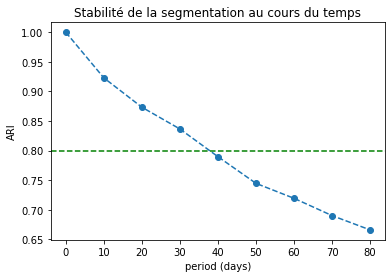

In [18]:
fig, ax = plt.subplots()
ax.plot(periods,ARI, linestyle="--", marker="o")
plt.axhline(0.80, c='g', linestyle= '--')
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
ax.set_title('Stabilité de la segmentation au cours du temps')
plt.show()